In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from sklearn.metrics import r2_score
pd.set_option('display.max_columns', None)

In [2]:
# set up dataframes
# https://www.kaggle.com/datasets/christophercorrea/prisoners-and-crime-in-united-states
JailDeaths = pd.read_csv("datasets/all_deaths.csv", encoding='latin-1')
JailStats = pd.read_csv("datasets/all_jails.csv", encoding='latin-1')

# https://www.kaggle.com/datasets/noriuk/us-education-datasets-unification-project
Education_ByState = pd.read_csv("datasets/states_all.csv", encoding='latin-1')

# https://bjs.ojp.gov/library/publications/prisoners-2021-statistical-tables#:~:text=The%20U.S.%20prison%20population%20was,decrease%20from%202011%20(1%2C599%2C000)
p21stt01 = pd.read_csv("datasets/p21stt01.csv", encoding='latin-1')
p21stat02 = pd.read_csv("datasets/p21stat02.csv", encoding='latin-1')

Education_ByState

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,NaN,NaN,731634.0,208.0,252.0,207.0,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,NaN,NaN,122487.0,NaN,NaN,NaN,NaN
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,NaN,NaN,673477.0,215.0,265.0,209.0,NaN
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,NaN,NaN,441490.0,210.0,256.0,211.0,NaN
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,NaN,NaN,5254844.0,208.0,261.0,202.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,2019_VIRGINIA,VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,247.0,287.0,224.0,262.0
1711,2019_WASHINGTON,WASHINGTON,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.0,286.0,220.0,266.0
1712,2019_WEST_VIRGINIA,WEST_VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,231.0,272.0,213.0,256.0
1713,2019_WISCONSIN,WISCONSIN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,242.0,289.0,220.0,267.0


In [3]:
# clean up states_all_extended
# set columns
Education_ByState.columns = [
    "State Key",
    "State",
    "Year",
    "Total Enrollment",
    "Total Revenue",
    "Federal Revenue",
    "State Revenue",
    "Local Revenue",
    "Total Expenditure",
    "Instruction Expenditure",
    "Support Services Expenditure",
    "Other Expenditure",
    "Capital Outlay Expenditure",
    "Total Enrollment (Pre-K)",
    "Total Enrollment (K)",
    "Total Enrollment (4)",
    "Total Enrollment (8)",
    "Total Enrollment (12)",
    "Total Enrollment (1-8)",
    "Total Enrollment (9-12)",
    "Total Enrollment (ALL)",
    "Average Math Score (4)",
    "Average Math Score (8)",
    "Average Reading Score (4)",
    "Average Reading Score (8)",
]

In [4]:
##Education Dataset Cleanup
Education_ByStateCleaned = Education_ByState.drop(['State Key'], axis = 1)
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['Year'] <= 2016]
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['Year'] >= 1992]
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['State'] != 'NATIONAL']
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['State'] != 'DODEA']

#Dropping rows that have NA values for Instruction Expenditure
Education_ByStateCleaned = Education_ByStateCleaned.dropna(subset= ['Instruction Expenditure'])



##Filtering Rows that have NAs for both enrollment estimates then filling one rows NAs with the other rows estimates. 
Education_ByStateCleaned[pd.notna(Education_ByStateCleaned['Total Enrollment']) | pd.notna(Education_ByStateCleaned['Total Enrollment (ALL)'])]
Education_ByStateCleaned['Total Enrollment'] = Education_ByStateCleaned['Total Enrollment'].fillna(Education_ByStateCleaned['Total Enrollment (ALL)'])
Education_ByStateCleaned.drop(['Total Enrollment (ALL)'], axis = 1)


#Adding Expenditure Per Student To Clean DF
Education_ByStateCleaned['Expenditure Per Student'] = Education_ByStateCleaned['Instruction Expenditure'] / Education_ByStateCleaned['Total Enrollment']

In [5]:
##Exploring The Data

##Expenditure Per Student By State
EducationExp = Education_ByStateCleaned

#Selecting appropriate columns
EducationExp = EducationExp[['State', 'Year', 'Expenditure Per Student', 'Average Math Score (4)']]

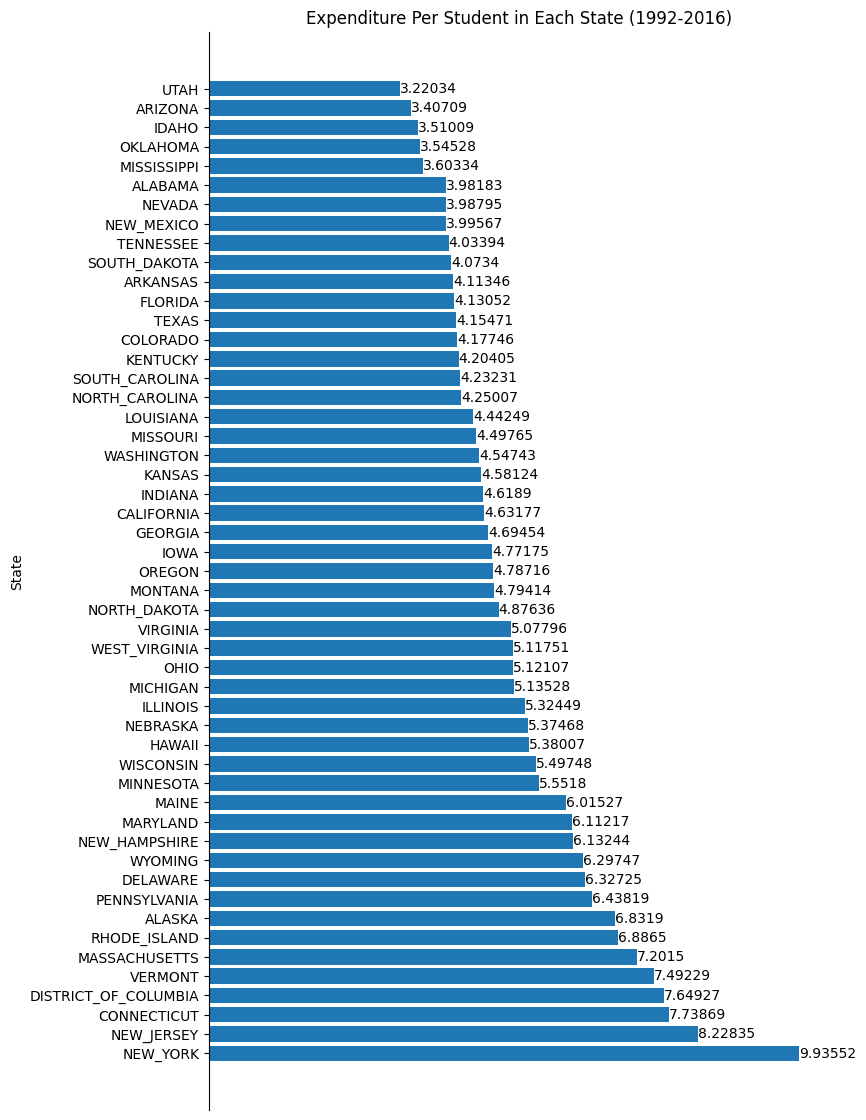

In [6]:
#Creating Groupedby DF
EducationExpGroupby = Education_ByStateCleaned.groupby('State').mean()
EducationExpGroupby = EducationExpGroupby.reset_index().sort_values('Expenditure Per Student', ascending= False)
EducationExpGroupby.index = EducationExpGroupby['State'] 

#Graphing Expenditure
fig, ax = plt.subplots(figsize=(8,14))
bars = plt.barh(EducationExpGroupby['State'],EducationExpGroupby['Expenditure Per Student'])
plt.style.use('seaborn-v0_8-notebook')
plt.ylabel("State")
ax.spines[['right','top','bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars)

plt.title("Expenditure Per Student in Each State (1992-2016)")
plt.show()

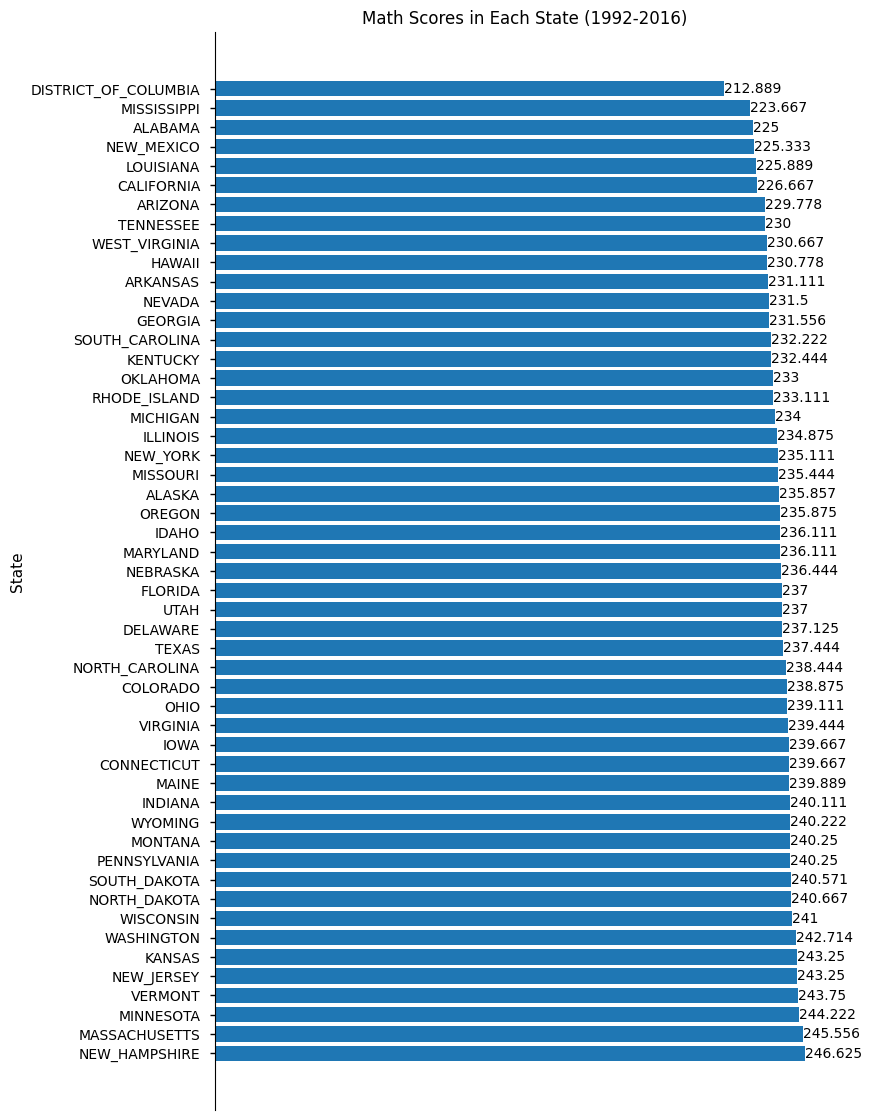

In [7]:
#Graphing Math Scores
EducationExpGroupby = EducationExpGroupby.sort_values('Average Math Score (4)', ascending= False)
fig, ax = plt.subplots(figsize=(8,14))
bars = plt.barh(EducationExpGroupby['State'],EducationExpGroupby['Average Math Score (4)'])
plt.style.use('seaborn-v0_8-notebook')
plt.ylabel("State")
ax.spines[['right','top','bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars)

plt.title("Math Scores in Each State (1992-2016)")
plt.show()

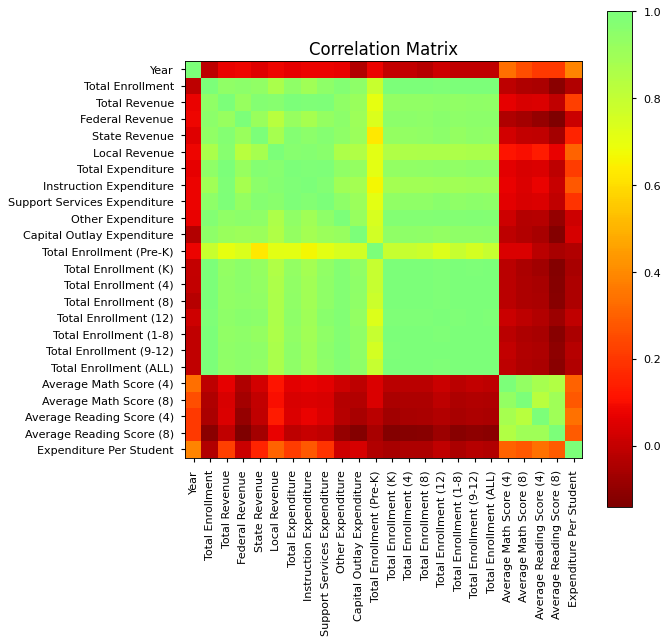

-0.13302882980495487

In [8]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#Exploring Correlations Between Variables
CorrelationEducation = Education_ByStateCleaned

#Create Expenditure By Student
# CorrelationEducation['Expenditure Per Student'] = CorrelationEducation['Instruction Expenditure'] / CorrelationEducation['Total Enrollment']
CorrelationEducation = CorrelationEducation.drop(['State'], axis = 1)
CorrelationEducation = CorrelationEducation[
    pd.notna(CorrelationEducation['Average Math Score (4)']) & pd.notna(CorrelationEducation['Average Math Score (8)'])]


# Scaling data
Scaler = StandardScaler()
Scaler.fit(CorrelationEducation)
CorrelationEducation = pd.DataFrame(Scaler.transform(CorrelationEducation), 
        columns= CorrelationEducation.columns)

#Creating Correlation Matrix
corr = CorrelationEducation.dropna().corr()
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
col_map = truncate_colormap(plt.get_cmap('jet'), 1, .5)
corrMat = plt.matshow(corr, cmap= col_map,fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrMat)
plt.title(f'Correlation Matrix', fontsize=15)
plt.show()

#Selecting Certain Correlations From The Matrix
CorrelationEducation['Capital Outlay Expenditure'].corr(CorrelationEducation['Average Reading Score (8)'])


In [9]:
#Creating Linear Regression Models
import math
MSEList = []

#Model1
Model1Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year']]
Model1Data = Model1Data[pd.notna(Model1Data['Average Math Score (4)']) & pd.notna(Model1Data['Average Math Score (8)']) 
                                        & pd.notna(Model1Data['Expenditure Per Student']) & pd.notna(Model1Data['Year'])]
TestingFloor = math.floor(len(Model1Data) * .8)
Model1DataTraining = Model1Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year']].iloc[0:TestingFloor]
Model1DataTesting = Model1Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year']].iloc[TestingFloor:]


model = LinearRegression(fit_intercept= True)
XTraining = Model1DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year']]
YTraining = Model1DataTraining['Average Math Score (8)']
XTesting = Model1DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year']]
YTesting = Model1DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
MSEList.append(metrics.mean_squared_error(ModelPredictions, YTesting))

#Model2
Model2Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)']]
Model2Data = Model2Data[pd.notna(Model2Data['Average Math Score (4)']) & pd.notna(Model2Data['Average Math Score (8)']) 
                                        & pd.notna(Model2Data['Expenditure Per Student']) & pd.notna(Model2Data['Year'])
                                        & pd.notna(Model2Data['Average Reading Score (4)'])]
TestingFloor = math.floor(len(Model2Data) * .8)
Model2DataTraining = Model2Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)']].iloc[0:TestingFloor]
Model2DataTesting = Model2Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)']].iloc[TestingFloor:]

model = LinearRegression(fit_intercept= True)
XTraining = Model2DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)']]
YTraining = Model2DataTraining['Average Math Score (8)']
XTesting = Model2DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)']]
YTesting = Model2DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
MSEList.append(metrics.mean_squared_error(ModelPredictions, YTesting))

#Model3
Model3Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
Model3Data = Model3Data[pd.notna(Model3Data['Average Math Score (4)']) & pd.notna(Model3Data['Average Math Score (8)']) 
                                        & pd.notna(Model3Data['Expenditure Per Student']) & pd.notna(Model3Data['Year'])
                                        & pd.notna(Model3Data['Average Reading Score (4)']) & pd.notna(Model3Data['Average Reading Score (8)'])]
TestingFloor = math.floor(len(Model3Data) * .8)
Model3DataTraining = Model3Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:TestingFloor]
Model3DataTesting = Model3Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[TestingFloor:]

model = LinearRegression(fit_intercept= True)
XTraining = Model3DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = Model3DataTraining['Average Math Score (8)']
XTesting = Model3DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = Model3DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
MSEList.append(metrics.mean_squared_error(ModelPredictions, YTesting))

#Model 4 (Final Model)

Model4Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Average Reading Score (4)', 'Average Reading Score (8)']]
Model4Data = Model4Data[pd.notna(Model4Data['Average Math Score (4)']) & pd.notna(Model4Data['Average Math Score (8)']) 
                                        & pd.notna(Model4Data['Expenditure Per Student']) & pd.notna(Model4Data['Average Reading Score (4)']) & pd.notna(Model4Data['Average Reading Score (8)'])]
Model4DataTraining = Model4Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:285]
Model4DataTesting = Model4Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[285:]

model = LinearRegression(fit_intercept= True)
XTraining = Model4DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = Model4DataTraining['Average Math Score (8)']
XTesting = Model4DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = Model4DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
MSEList.append(metrics.mean_squared_error(ModelPredictions, YTesting))

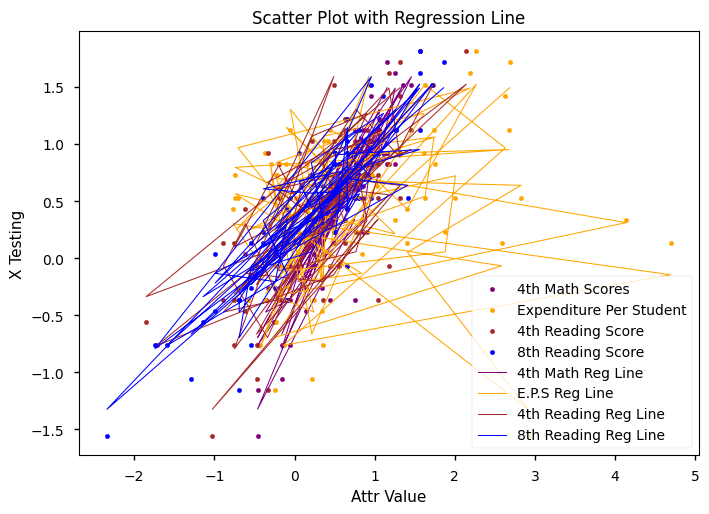

In [10]:
plt.scatter(XTesting['Average Math Score (4)'],YTesting, color='purple', label='4th Math Scores',s=10)
plt.scatter(XTesting['Expenditure Per Student'],YTesting, color='orange', label='Expenditure Per Student',s=10)
plt.scatter( XTesting['Average Reading Score (4)'],YTesting, color='brown', label='4th Reading Score',s=10)
plt.scatter( XTesting['Average Reading Score (8)'],YTesting, color='blue', label='8th Reading Score',s=10)

# Regression line
plt.plot(XTesting['Average Math Score (4)'], ModelPredictions, color='purple', linewidth=.75, label='4th Math Reg Line')
plt.plot(XTesting['Expenditure Per Student'], ModelPredictions, color='orange', linewidth=.75, label='E.P.S Reg Line')
plt.plot(XTesting['Average Reading Score (4)'], ModelPredictions, color='brown', linewidth=.75, label='4th Reading Reg Line')
plt.plot(XTesting['Average Reading Score (8)'], ModelPredictions, color='blue', linewidth=.75, label='8th Reading Reg Line')

# Add labels and title
plt.ylabel('X Testing')
plt.xlabel('Attr Value')
plt.title('Scatter Plot with Regression Line')

# Add legend
plt.legend()

# Display the plot
plt.show()

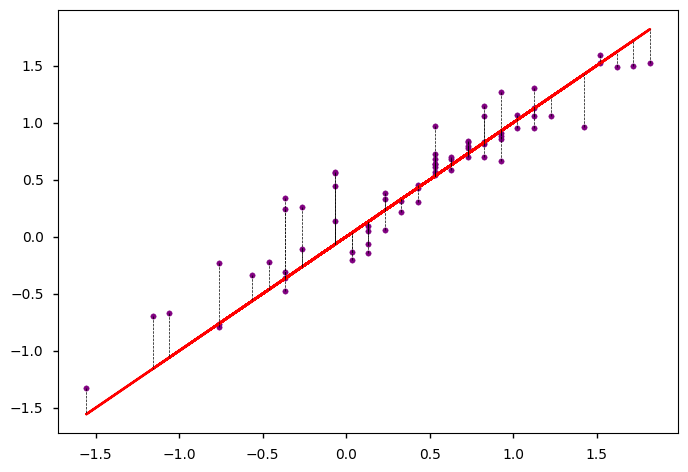

In [11]:
plt.scatter(YTesting,ModelPredictions, color='purple', label='Total Enrollment',s=15)

# Create the regression line using the calculated coefficients
regression_line = YTesting 

plt.plot(YTesting, regression_line, color='red', label='Regression Line')

for x, y, ln in zip(YTesting, ModelPredictions, regression_line):
    plt.plot([x, x], [y, ln], color='black', linestyle='--', linewidth=0.5)

plt.show()

In [12]:
#Polynomial Model
PolynomialModelData = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
PolynomialModelData = PolynomialModelData[pd.notna(PolynomialModelData['Average Math Score (4)']) & pd.notna(PolynomialModelData['Average Math Score (8)']) 
                                        & pd.notna(PolynomialModelData['Expenditure Per Student']) & pd.notna(PolynomialModelData['Year'])
                                        & pd.notna(PolynomialModelData['Average Reading Score (4)']) & pd.notna(PolynomialModelData['Average Reading Score (8)'])]
TestingFloor = math.floor(len(PolynomialModelData) * .8)
PolynomialModelDataTraining = PolynomialModelData[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:TestingFloor]
PolynomialModelDataTesting = PolynomialModelData[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[TestingFloor:]

polyFinalModel = make_pipeline(PolynomialFeatures(2, include_bias = False),LinearRegression())
XTraining = PolynomialModelDataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = PolynomialModelDataTraining['Average Math Score (8)']
polyFinalModel.fit(XTraining, YTraining)
XTesting = PolynomialModelDataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = PolynomialModelDataTesting['Average Math Score (8)']
YPred = polyFinalModel.predict(XTesting)
MSEList.append(metrics.mean_squared_error(ModelPredictions, YTesting))

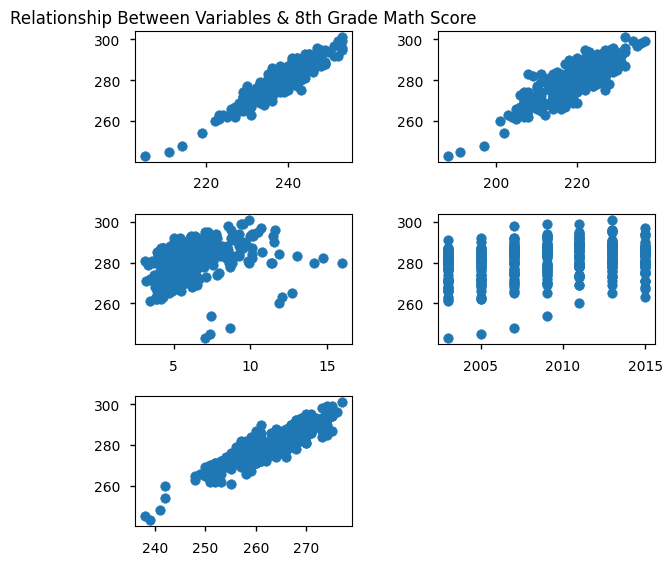

In [13]:
# Exploring why a linear regression outperforms polynomial regression.


# Filter Proper Rows
PMEXPFILTERED = Education_ByStateCleaned[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
PMEXPFILTERED = PMEXPFILTERED[pd.notna(PMEXPFILTERED['Average Math Score (4)']) & pd.notna(PMEXPFILTERED['Average Math Score (8)']) 
                                        & pd.notna(PMEXPFILTERED['Expenditure Per Student']) & pd.notna(PMEXPFILTERED['Year'])
                                        & pd.notna(PMEXPFILTERED['Average Reading Score (4)']) & pd.notna(PMEXPFILTERED['Average Reading Score (8)'])]
plt.subplot(3,2,1)
plt.scatter(PMEXPFILTERED['Average Math Score (4)'], PMEXPFILTERED['Average Math Score (8)'])
plt.title('Relationship Between Variables & 8th Grade Math Score')

plt.subplot(3,2,2)
plt.scatter(PMEXPFILTERED['Average Reading Score (4)'], PMEXPFILTERED['Average Math Score (8)'])

plt.subplot(3,2,3)
plt.scatter(PMEXPFILTERED['Expenditure Per Student'], PMEXPFILTERED['Average Math Score (8)'])

plt.subplot(3,2,4)
plt.scatter(PMEXPFILTERED['Year'], PMEXPFILTERED['Average Math Score (8)'])

plt.subplot(3,2,5)
plt.scatter(PMEXPFILTERED['Average Reading Score (8)'], PMEXPFILTERED['Average Math Score (8)'])

plt.subplots_adjust(left=.1,
                    bottom=.1,
                    right=0.75,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)

In [14]:
#Neural Network Regression
NNData = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
NNData = NNData[pd.notna(NNData['Average Math Score (4)']) & pd.notna(NNData['Average Math Score (8)']) 
                                        & pd.notna(NNData['Expenditure Per Student']) & pd.notna(NNData['Year'])
                                        & pd.notna(NNData['Average Reading Score (4)']) & pd.notna(NNData['Average Reading Score (8)'])]
TestingFloor = math.floor(len(NNData) * .8)
NNDataDataTraining = NNData[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:TestingFloor]
NNDataDataTesting = NNData[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[TestingFloor:]

XTraining = NNDataDataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = NNDataDataTraining['Average Math Score (8)']

XTesting = NNDataDataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = NNDataDataTesting['Average Math Score (8)']


#Filter Proper Rows
model = models.Sequential()
model.add(layers.Dense(5,activation='relu', 
					input_shape=(5,)))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(XTraining,YTraining, epochs = 50)
results = model.evaluate(XTesting, YTesting)


MSEList.append(results[1])

Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.8386 - mean_squared_error: 0.8386
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.8146 - mean_squared_error: 0.8146
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.7943 - mean_squared_error: 0.7943
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.7827 - mean_squared_error: 0.7827
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 0.7766 - mean_squared_error: 0.7766
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.7741 - mean_squared_error: 0.7741
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.7719 - mean_squared_error: 0.7719
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.7701 - mean_squared_error: 0.7701
Epoch 9/50
9/9 [==============================] - 0s 1ms/step - loss: 0.7686 - mean_squared_error: 0.7686
Epoch 10/50
9/9 [=============================

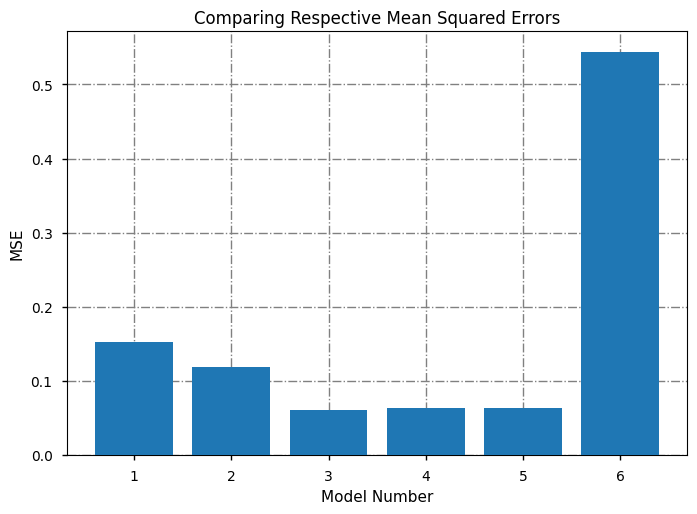

In [15]:
#Graphing MSE Per Model
# plt.bar()
ModelNumber = [1,2,3,4,5,6]
plt.grid(True, zorder = 0, color = "grey", linewidth = "1", linestyle = "-.")
plt.bar(ModelNumber,MSEList,zorder=3)
plt.title("Comparing Respective Mean Squared Errors")
plt.xlabel("Model Number")
plt.ylabel("MSE")
plt.show()

In [16]:
#Importing Jail Data
# https://www.kaggle.com/datasets/christophercorrea/prisoners-and-crime-in-united-states?select=crime_and_incarceration_by_state.csv
crimesAndIncarcerationsByState = pd.read_csv("datasets/crime_and_incarceration_by_state.csv", encoding='latin-1')
prisonCustodyByState = pd.read_csv("datasets/prison_custody_by_state.csv", encoding='latin-1')
crimeTotalsByState = pd.read_csv("datasets/ucr_by_state.csv", encoding='latin-1')

In [17]:
#crimetotal cleanup
crimeTotalsByStateCleaned = crimeTotalsByState.drop(["Unnamed: 15", "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "crime_reporting_change", "crimes_estimated", "rape_legacy", 'rape_revised'], axis=1)
crimeTotalsByStateCleaned = crimeTotalsByStateCleaned.drop(range(869, 948)).reset_index(drop=True)
crimeTotalsByStateCleaned = crimeTotalsByStateCleaned.rename(columns={"ï»¿jurisdiction": "State", "year": "Year"})
crimeTotalsByStateCleaned["Year"] = crimeTotalsByStateCleaned["Year"].astype(int)
crimeTotalsByStateCleaned = crimeTotalsByStateCleaned[crimeTotalsByStateCleaned['Year'] >= 2001]
crimeTotalsByStateCleaned = crimeTotalsByStateCleaned[crimeTotalsByStateCleaned['Year'] <= 2016]

crimeTotalsByStateCleaned['State'] = crimeTotalsByStateCleaned['State'].str.upper()

#Cleaning all the columns with commas and converting to int
crimeTotalsByStateCleaned['state_population'] = crimeTotalsByStateCleaned['state_population'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['violent_crime_total'] = crimeTotalsByStateCleaned['violent_crime_total'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['murder_manslaughter'] = crimeTotalsByStateCleaned['murder_manslaughter'].str.replace(',', '').astype(int)
# crimeTotalsByStateCleaned['rape_legacy'] = crimeTotalsByStateCleaned['rape_legacy'].str.replace(',', '').astype(int)
# crimeTotalsByStateCleaned['rape_revised'] = crimeTotalsByStateCleaned['rape_revised'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['robbery'] = crimeTotalsByStateCleaned['robbery'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['agg_assault'] = crimeTotalsByStateCleaned['agg_assault'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['property_crime_total'] = crimeTotalsByStateCleaned['property_crime_total'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['burglary'] = crimeTotalsByStateCleaned['burglary'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['larceny'] = crimeTotalsByStateCleaned['larceny'].str.replace(',', '').astype(int)
crimeTotalsByStateCleaned['vehicle_theft'] = crimeTotalsByStateCleaned['vehicle_theft'].str.replace(',', '').astype(int)

crimeTotalsByStateCleaned = crimeTotalsByStateCleaned.rename(columns={"state_population": "State Population", 
                                                                      "violent_crime_total": "Violent Total Crime",
                                                                      "murder_manslaughter": "Murder",
                                                                      "rape_revised": "Rape(Revised)",
                                                                      "robbery": "Robbery",
                                                                      "agg_assault": "Agg Assault",
                                                                      "property_crime_total": "Property Crime Total",
                                                                      "burglary": "Burglary",
                                                                      "larceny": "Larceny",
                                                                      "vehicle_theft": "Vehicle Theft"})

In [18]:
#Merging DFs
CrimeEducationMerged = pd.merge(Education_ByStateCleaned, crimeTotalsByStateCleaned, on=['State', 'Year'])

pd.set_option('display.max_columns', None)
display(CrimeEducationMerged)

,State,Year,Total Enrollment,Total Revenue,Federal Revenue,State Revenue,Local Revenue,Total Expenditure,Instruction Expenditure,Support Services Expenditure,Other Expenditure,Capital Outlay Expenditure,Total Enrollment (Pre-K),Total Enrollment (K),Total Enrollment (4),Total Enrollment (8),Total Enrollment (12),Total Enrollment (1-8),Total Enrollment (9-12),Total Enrollment (ALL),Average Math Score (4),Average Math Score (8),Average Reading Score (4),Average Reading Score (8),Expenditure Per Student,State Population,Violent Total Crime,Murder,Robbery,Agg Assault,Property Crime Total,Burglary,Larceny,Vehicle Theft
0,ALABAMA,2001,728532.0,4832946.0,466150.0,2879636.0,1487160.0,5086045.0,2656393.0,1374265.0,426481.0,540284.0,11841.0,54148.0,58929.0,56591.0,42909.0,469591.0,201610.0,737190.0,NaN,NaN,NaN,NaN,3.646227,4468912,19582,379,5584,12250,173253,40642,119992,12619
1,ALASKA,2001,131985.0,1325498.0,229297.0,732985.0,363216.0,1402839.0,701053.0,479510.0,48312.0,150279.0,1253.0,10095.0,10718.0,10702.0,8340.0,83540.0,39461.0,134358.0,NaN,NaN,NaN,NaN,5.311611,633630,3735,39,514,2681,23160,3847,16695,2618
2,ARIZONA,2001,834387.0,5916342.0,580043.0,2729793.0,2606506.0,5858385.0,2538936.0,1701945.0,269157.0,1035457.0,6624.0,72119.0,74270.0,69643.0,52162.0,585206.0,249920.0,922180.0,NaN,NaN,NaN,NaN,3.042876,5306966,28675,400,8868,17889,293874,54821,186850,52203
3,ARKANSAS,2001,449693.0,2974588.0,274406.0,2135281.0,564901.0,2951677.0,1616883.0,877225.0,153300.0,235346.0,1623.0,34981.0,35216.0,35372.0,28849.0,280237.0,131418.0,449805.0,NaN,NaN,NaN,NaN,3.595526,2694698,12190,148,2181,8969,99106,22196,69590,7320
4,CALIFORNIA,2001,6045030.0,53288943.0,4280358.0,31374889.0,17633696.0,52082540.0,26641811.0,14127664.0,2570224.0,6755895.0,100351.0,457165.0,485301.0,461133.0,365907.0,3871843.0,1745295.0,6247726.0,NaN,NaN,NaN,NaN,4.407226,34600463,212867,2206,64614,136087,1134189,232273,697739,204177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,VIRGINIA,2014,1273211.0,15347862.0,1009659.0,5994897.0,8343306.0,15690444.0,8464947.0,4964725.0,619387.0,1041633.0,32839.0,93758.0,95200.0,95558.0,88256.0,771091.0,382598.0,1280381.0,NaN,NaN,NaN,NaN,6.648503,8326289,16340,338,4292,9400,160720,23122,129933,7665
557,WASHINGTON,2014,1057773.0,13040197.0,1030232.0,7833024.0,4176941.0,12806300.0,6267816.0,4035948.0,549588.0,1525815.0,12663.0,81212.0,79721.0,80391.0,87206.0,646445.0,333318.0,1073638.0,NaN,NaN,NaN,NaN,5.925483,7061530,20136,174,5640,11627,261706,55290,175769,30647
558,WISCONSIN,2014,865119.0,11330253.0,830568.0,5709579.0,4790106.0,11255186.0,5685955.0,3616770.0,498431.0,767074.0,55831.0,60424.0,60795.0,62034.0,65954.0,490627.0,264550.0,871432.0,NaN,NaN,NaN,NaN,6.572454,5757564,16714,165,5066,9809,120238,21216,89103,9919
559,WYOMING,2014,92732.0,1772633.0,112709.0,965213.0,694711.0,1775999.0,865932.0,555761.0,50715.0,287977.0,564.0,7997.0,7438.0,6927.0,6133.0,58774.0,26732.0,94067.0,NaN,NaN,NaN,NaN,9.338006,584153,1142,16,53,899,11477,1689,9185,603


In [19]:
##Exploring The Jail Data

##Support Expenditure Per Student By State
EducationSupportExp = CrimeEducationMerged

#Selecting appropriate columns
EducationSupportExp = EducationSupportExp[['State', 'Year', 'Total Enrollment', 'Support Services Expenditure','Vehicle Theft']]

#Create Expenditure By Student
EducationSupportExp['Support Per Student'] = EducationSupportExp['Support Services Expenditure'] / EducationSupportExp['Total Enrollment']
EducationSupportExpGroupby = EducationSupportExp.groupby('State').mean()
EducationSupportExpGroupby = EducationSupportExpGroupby.reset_index().sort_values('Support Per Student', ascending= False)

EducationSupportExpGroupby.index = EducationSupportExpGroupby['State'] 

C:\Users\Andrew Martinez\AppData\Local\Temp\ipykernel_9544\123953855.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EducationSupportExp['Support Per Student'] = EducationSupportExp['Support Services Expenditure'] / EducationSupportExp['Total Enrollment']


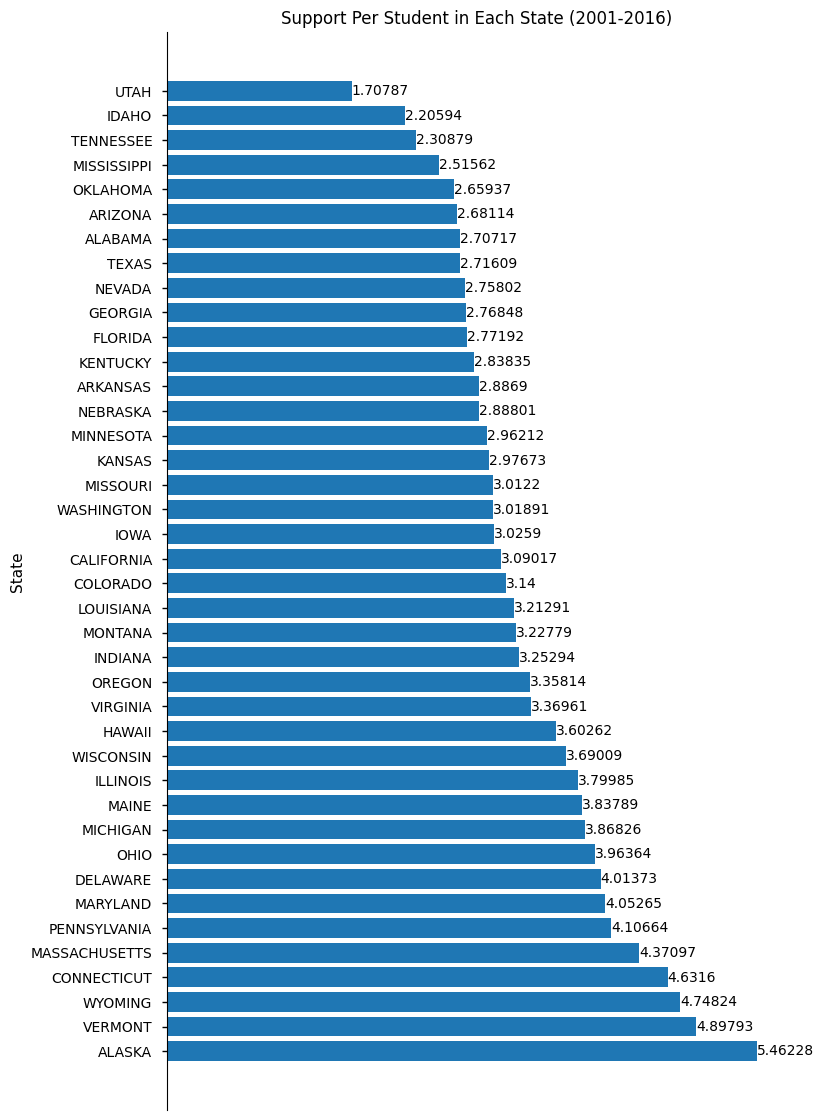

In [20]:
#Creating Groupedby DF
EducationSupportExpGroupby = EducationSupportExp.groupby('State').mean()
EducationSupportExpGroupby = EducationSupportExpGroupby.reset_index().sort_values('Support Per Student', ascending= False)
EducationSupportExpGroupby.index = EducationSupportExpGroupby['State'] 

#Graphing Support
fig, ax = plt.subplots(figsize=(8,14))
bars = plt.barh(EducationSupportExpGroupby['State'],EducationSupportExpGroupby['Support Per Student'])
plt.style.use('seaborn-v0_8-notebook')
plt.ylabel("State")
ax.spines[['right','top','bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars)

plt.title("Support Per Student in Each State (2001-2016)")
plt.show()

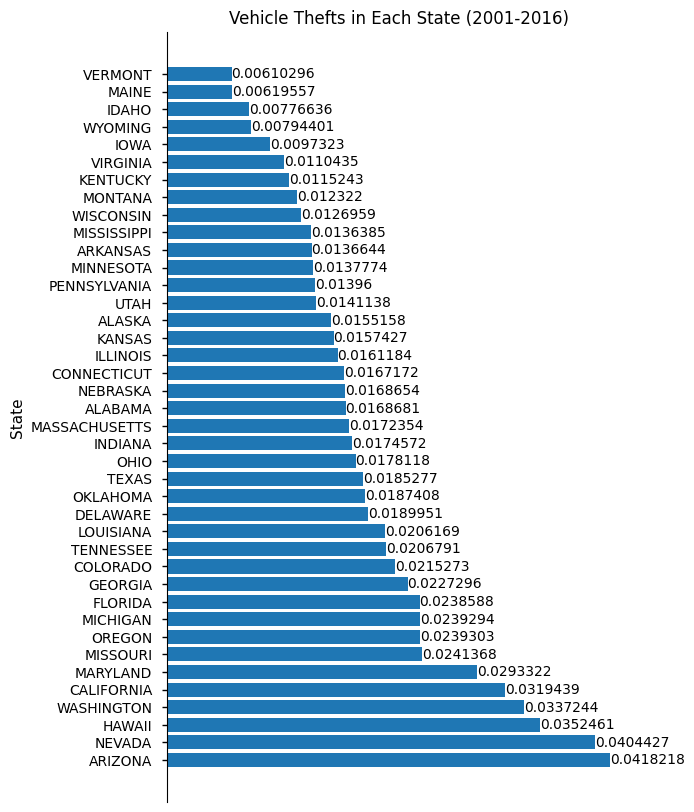

In [21]:
EducationSupportExpGroupby = EducationSupportExp.groupby('State').mean()
EducationSupportExpGroupby['Theft Per Student Enrolled'] = EducationSupportExpGroupby['Vehicle Theft']/EducationSupportExpGroupby['Total Enrollment']
EducationSupportExpGroupby = EducationSupportExpGroupby.reset_index().sort_values('Theft Per Student Enrolled', ascending= False)
fig, ax = plt.subplots(figsize=(6,10))
# divided by enrollment to add size of state to consideration
bars = plt.barh(EducationSupportExpGroupby['State'],EducationSupportExpGroupby['Theft Per Student Enrolled'])
plt.style.use('seaborn-v0_8-notebook')
plt.ylabel("State")
ax.spines[['right','top','bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars)

plt.title("Vehicle Thefts in Each State (2001-2016)")
plt.show()

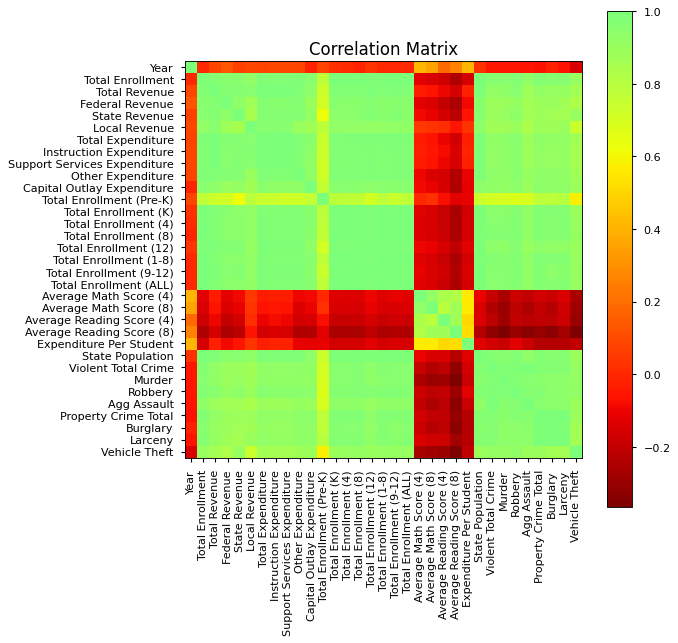

0.8496281698847823

In [22]:
#Exploring Correlations Between Variables
CorrelationCrime = CrimeEducationMerged

#Create Expenditure By Student
CorrelationCrime = CorrelationCrime.drop(['State'], axis = 1)
# CorrelationCrime = CorrelationCrime[pd.notna(CorrelationEducation['Average Math Score (4)']) & pd.notna(CorrelationEducation['Average Math Score (8)'])]


# Scaling data
Scaler = StandardScaler()
Scaler.fit(CorrelationCrime)
CorrelationCrime = pd.DataFrame(Scaler.transform(CorrelationCrime), 
        columns= CorrelationCrime.columns)

#Creating Correlation Matrix
corr = CorrelationCrime.dropna().corr()
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
corrMat = plt.matshow(corr, cmap=col_map,fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrMat)
plt.title(f'Correlation Matrix', fontsize=15)
plt.show()

#Selecting Certain Correlations From The Matrix
CorrelationCrime['Support Services Expenditure'].corr(CorrelationCrime['Vehicle Theft'])

In [23]:
#Predicting Vehicle Theft

#Creating ADJ R2 List
ADJR2List= []

#MSE List
MSEListJail = []

#Model 1
Model1Data = CrimeEducationMerged[['Violent Total Crime', 'Support Services Expenditure', 'Vehicle Theft']]
Model1Data = Model1Data[pd.notna(Model1Data['Violent Total Crime']) & pd.notna(Model1Data['Support Services Expenditure']) & 
                        pd.notna(Model1Data['Vehicle Theft'])]

TestingFloor = math.floor(len(Model1Data) * .8)
Model1DataTraining = Model1Data.iloc[0:TestingFloor]
Model1DataTesting = Model1Data.iloc[TestingFloor:]


model = LinearRegression(fit_intercept= True)
XTraining = Model1DataTraining[['Violent Total Crime', 'Support Services Expenditure']]
YTraining = Model1DataTraining['Vehicle Theft']
XTesting = Model1DataTesting[['Violent Total Crime', 'Support Services Expenditure']]

print(XTesting)
print(len(XTesting))

YTesting = Model1DataTesting['Vehicle Theft']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
MSEListJail.append(metrics.mean_squared_error(ModelPredictions, YTesting))
ADJR2List.append((1-(1-r2_score(YTesting, ModelPredictions))*((len(XTesting)-1)/(len(XTesting)-len(XTesting.columns)-1))))

#Model2 
Model2Data = CrimeEducationMerged[['Violent Total Crime', 'Support Services Expenditure', 'Vehicle Theft', 'State Revenue']]
Model2Data = Model2Data[pd.notna(Model2Data['Violent Total Crime']) & pd.notna(Model2Data['Support Services Expenditure']) & 
                        pd.notna(Model2Data['Vehicle Theft']) & pd.notna(Model2Data['State Revenue'])]

TestingFloor = math.floor(len(Model2Data) * .8)
Model2DataTraining = Model2Data.iloc[0:TestingFloor]
Model2DataTesting = Model2Data.iloc[TestingFloor:]


model = LinearRegression(fit_intercept= True)
XTraining = Model2DataTraining[['Violent Total Crime', 'Support Services Expenditure', 'State Revenue']]
YTraining = Model2DataTraining['Vehicle Theft']
XTesting = Model2DataTesting[['Violent Total Crime', 'Support Services Expenditure', 'State Revenue']]
YTesting = Model2DataTesting['Vehicle Theft']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
MSEListJail.append(metrics.mean_squared_error(ModelPredictions, YTesting))
ADJR2List.append((1-(1-r2_score(YTesting, ModelPredictions))*((len(XTesting)-1)/(len(XTesting)-len(XTesting.columns)-1))))

#Polynomial Model
PolyModel = CrimeEducationMerged[['Violent Total Crime', 'Support Services Expenditure', 'Vehicle Theft', 'State Revenue']]
PolyModel = PolyModel[pd.notna(PolyModel['Violent Total Crime']) & pd.notna(PolyModel['Support Services Expenditure']) & 
                        pd.notna(PolyModel['Vehicle Theft']) & pd.notna(PolyModel['State Revenue'])]

TestingFloor = math.floor(len(PolyModel) * .8)
PolyModelTraining = PolyModel.iloc[0:TestingFloor]
PolyModelTesting = PolyModel.iloc[TestingFloor:]


model = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept= True))
XTraining = PolyModelTraining[['Violent Total Crime', 'Support Services Expenditure', 'State Revenue']]
YTraining = PolyModelTraining['Vehicle Theft']
XTesting = PolyModelTesting[['Violent Total Crime', 'Support Services Expenditure', 'State Revenue']]
YTesting = PolyModelTesting['Vehicle Theft']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
MSEListJail.append(metrics.mean_squared_error(ModelPredictions, YTesting))
ADJR2List.append((1-(1-r2_score(YTesting, ModelPredictions))*((len(XTesting)-1)/(len(XTesting)-len(XTesting.columns)-1))))

#EducationModel
Model2Data = CrimeEducationMerged[['Support Services Expenditure', 'Vehicle Theft', 'State Revenue', 'Total Enrollment']]
Model2Data = Model2Data[pd.notna(Model2Data['Total Enrollment']) & pd.notna(Model2Data['Support Services Expenditure']) & 
                        pd.notna(Model2Data['Vehicle Theft']) & pd.notna(Model2Data['State Revenue'])]

TestingFloor = math.floor(len(Model2Data) * .8)
Model2DataTraining = Model2Data.iloc[0:TestingFloor]
Model2DataTesting = Model2Data.iloc[TestingFloor:]


model = LinearRegression(fit_intercept= True)
XTraining = Model2DataTraining[['Total Enrollment', 'Support Services Expenditure', 'State Revenue']]
YTraining = Model2DataTraining['Vehicle Theft']
XTesting = Model2DataTesting[['Total Enrollment', 'Support Services Expenditure', 'State Revenue']]
YTesting = Model2DataTesting['Vehicle Theft']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
print(metrics.r2_score(ModelPredictions, YTesting))
MSEListJail.append(metrics.mean_squared_error(ModelPredictions, YTesting))
ADJR2List.append((1-(1-r2_score(YTesting, ModelPredictions))*((len(XTesting)-1)/(len(XTesting)-len(XTesting.columns)-1))))


#Visualize the Models????
#Scatter plot the Xtesting and Y Testing and add regression as a line. 

     Violent Total Crime  Support Services Expenditure
448                94087                     7607362.0
449                37675                     5043644.0
450                 3378                      814511.0
451                 3348                      609786.0
452                53556                     9358604.0
..                   ...                           ...
556                16340                     4964725.0
557                20136                     4035948.0
558                16714                     3616770.0
559                 1142                      555761.0
560                17647                     3691809.0

[113 rows x 2 columns]
113
0.8417646821582249


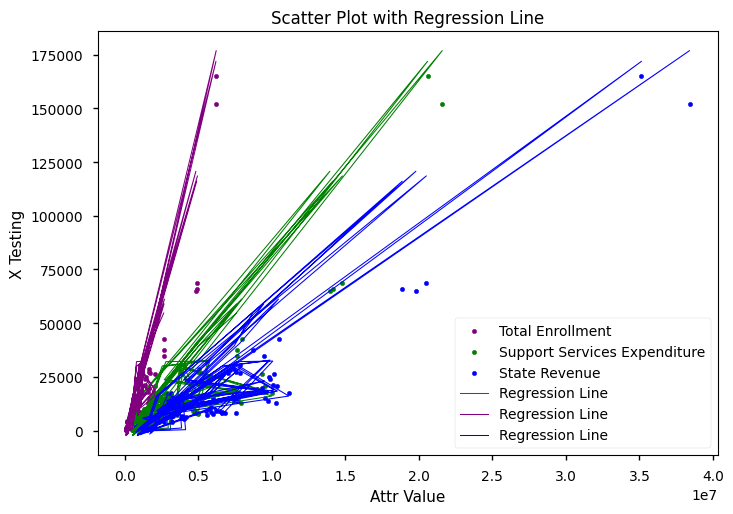

In [24]:
plt.scatter(XTesting['Total Enrollment'],YTesting, color='purple', label='Total Enrollment',s=10)
plt.scatter(XTesting['Support Services Expenditure'],YTesting, color='green', label='Support Services Expenditure',s=10)
plt.scatter( XTesting['State Revenue'],YTesting, color='blue', label='State Revenue',s=10)

# Regression line
plt.plot(XTesting['Support Services Expenditure'], ModelPredictions, color='green', linewidth=.75, label='Regression Line')
plt.plot(XTesting['Total Enrollment'], ModelPredictions, color='purple', linewidth=.75, label='Regression Line')
plt.plot(XTesting['State Revenue'], ModelPredictions, color='blue', linewidth=.75, label='Regression Line')

# Add labels and title
plt.ylabel('X Testing')
plt.xlabel('Attr Value')
plt.title('Scatter Plot with Regression Line')

# Add legend
plt.legend()

# Display the plot
plt.show()

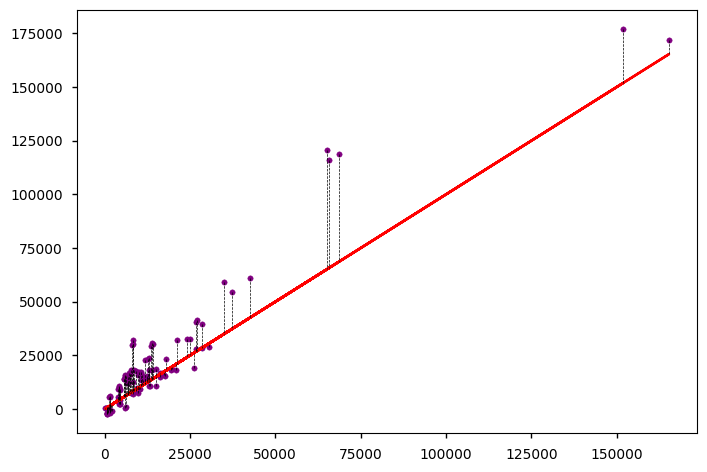

In [25]:
plt.scatter(YTesting,ModelPredictions, color='purple', label='Total Enrollment',s=15)

# Create the regression line using the calculated coefficients
regression_line = YTesting 

plt.plot(YTesting, regression_line, color='red', label='Regression Line')

for x, y, ln in zip(YTesting, ModelPredictions, regression_line):
    plt.plot([x, x], [y, ln], color='black', linestyle='--', linewidth=0.5)

plt.show()

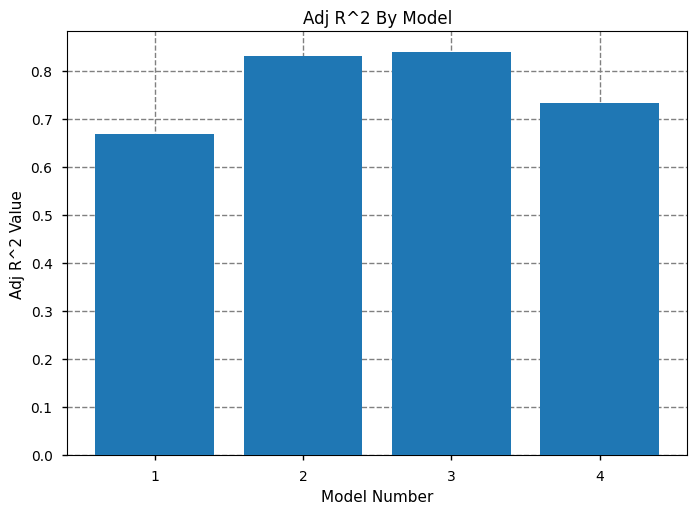

In [26]:
ModelNumber = ["1","2","3","4"]
plt.grid(True, zorder = 0, color = "grey", linewidth = "1", linestyle = "--")
plt.bar(ModelNumber,ADJR2List,zorder=3)
plt.title("Adj R^2 By Model")
plt.xlabel("Model Number")
plt.ylabel("Adj R^2 Value")
plt.show()